In [16]:
DATASET_PATH = "../output_frames.csv"

## Foundation

Include required libraries and tools under this section and adjust settings.

**TODO:**
- [ ] Explore the usage of garbage collections.

In [17]:
# Import required libraries.
import  tensorflow as tf

from    keras.models import Sequential
from    keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from    keras.utils import to_categorical

# Helper libraries.
import  pandas as pd
import  numpy as np
from    sklearn.model_selection import train_test_split
from    sklearn.preprocessing import LabelEncoder
import  librosa

# Libraries for plotting.
import  matplotlib.pyplot as plt

# Other
import sys
import os
import zipfile

In [18]:
# Test for GPU and determine what GPU we have.
# Modified by student to remove warningen caused on local machine.
IN_COLAB = 'google.colab' in sys.modules

gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    compute_capability=details.get('compute_capability')
    print("Compute capability:",compute_capability)
    if compute_capability[0]>6:
        print("Turn on mixed_float16")
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU detected.")

Compute capability: (7, 5)
Turn on mixed_float16


In [19]:
# Modify GPU memory allocator to try to prevent full GPU memory.
# This can in some cases be counter productive!
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [20]:
# Install Keras Tuner via PIP (if in colab).
if IN_COLAB:
    os.system('pip install keras_tuner')

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

Keras Tuner version: 1.4.7


## Import Dataset

If you're using Google Colab, the dataset has to be imported from Google Drive (or uploaded as a ZIP-file). This required giving permission to Google Colab! Otherwise, it will check if the dataset folder exists, if not, terminates the execution.

**TODO:**
- [ ] Add support for uploaded dataset.zip files.

In [21]:

if (not os.path.exists(DATASET_PATH)):
    print("Error: Dataset not found.")
    sys.exit()

In [22]:
df = pd.read_csv(DATASET_PATH, header=None)              # No header in your format
dataset = df.iloc[:, :-1].to_numpy(dtype=np.float16)            # All but last column as float16
labels_set = df.iloc[:, -1].to_numpy(dtype=str)                 # Last column as string

In [23]:
dataset = dataset.reshape(dataset.shape[0], 25, 16)
# Transpose each data point.
dataset = np.array([x.T for x in dataset])
input_shape = dataset[0].shape

print(f"Dataset shape: {dataset.shape}")
print(f"Labels shape: {labels_set.shape}")
print(f"Input shape: {input_shape}")

Dataset shape: (583554, 16, 25)
Labels shape: (583554,)
Input shape: (16, 25)


# Preparing dataset

To prepare the data, we first read through each frame file from the dataset and stores the path alongside it's label in array **dataset** and also addes the label, if not already existing, to **labels**.

We then prepare a function to reads TXT file data and convert it to NP array, followed by a function used for plotting int MFCC for debugging.

In [24]:
# Plot MFCC
def plot_mfcc(mfccs):
    # Flatten the data
    mfccs = mfccs.reshape((25, 16))
    # Plot the MFCC
    print(f"MFCC shape: {mfccs.shape}")
    mfccs = mfccs
    librosa.display.specshow(mfccs, x_axis='time', sr=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficient')
    plt.show()

MFCC shape: (25, 16)


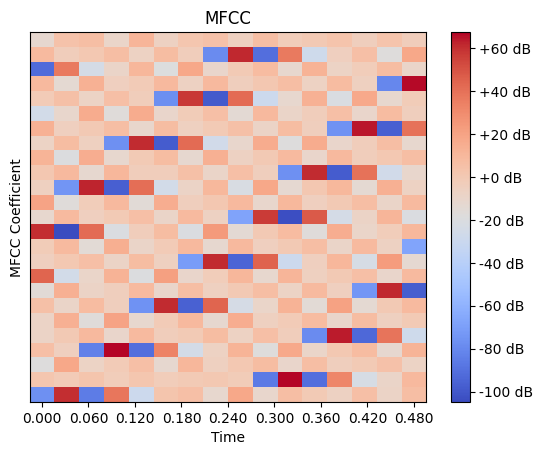

In [25]:
# Pass exmaple frame data to plot_mfcc function.
plot_mfcc(dataset[0])

### Splitting Dataset

When data have been explored, we split the data into three groups: training, validating, and testing. Where training and validating will be used for the training process, and testing for the final testing.

In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset, labels_set, test_size=0.2, random_state=42, stratify=labels_set)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Print the lengths of the training, validation, and testing sets.
print(f"Training set length: {len(x_train)}")
print(f"Validation set length: {len(x_val)}")
print(f"Testing set length: {len(x_test)}")

Training set length: 373474
Validation set length: 93369
Testing set length: 116711


In [27]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights.
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
dist_class_weight = dict(enumerate(class_weight))

In [28]:
print(f"Classes: {np.unique(labels_set)}")

Classes: ['Background_noise' 'Bus' 'Car' 'Motorcycle' 'Truck']


In [29]:
# Hot end code the labels.
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.fit_transform(y_test))
y_val = to_categorical(label_encoder.fit_transform(y_val))

# Helper Functions

There are two helper functions: printHistory (used for plotting graphs to udnerstand over- and udner-fitting), as well as fitModel (used for fitting model one or multiple times).

In [30]:
# Print training history
# Function used for printing two plots, one for accuracy and one for loss.
# To be used with the history object from the fit method
def printHistory(history):
  # Collect the number of epochs run based on the amount of loss value under history.
  epochs = len(history.history['loss'])

  epochrange = range(1, epochs + 1)
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(epochrange, train_acc, 'bo', label='Training acc')
  plt.plot(epochrange, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochrange, train_loss, 'bo', label='Training loss')
  plt.plot(epochrange, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss (modell 1)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [31]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

# Fit model function used for convinience when fitting the model multiple times
def fitModel(model, x_train, y_train, x_val, y_val, epochs, doPrintHistory, class_weight, verbose, batch_size):

    # Define early stopping callback.
    reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        verbose=verbose,
        class_weight=class_weight,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr_on_plateau],
    )
    # Print history
    if doPrintHistory: printHistory(history)

In [ ]:
print(input_shape)

(16, 25)


In [ ]:
print((input_shape[0], 1))

(16, 1)


# Construct Sequantial Model

...

In [32]:
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv1D, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, InputLayer
from tensorflow.keras.regularizers import l2

sequential_model = Sequential([

    InputLayer(shape=input_shape),  # 25 frames, 16 channels

    SeparableConv1D(filters=256, kernel_size=5, activation="swish", padding='same'),
    BatchNormalization(),
    SeparableConv1D(filters=512, kernel_size=5, activation="swish", padding='same'),
    BatchNormalization(),
    SeparableConv1D(filters=512, kernel_size=5, activation="swish", padding='same'),
    BatchNormalization(),
    SeparableConv1D(filters=1024, kernel_size=5, activation="swish", padding='same'),

    # Feature Pooling (Combining Max & Average Pooling)
    GlobalAveragePooling1D(),

    # Fully Connected Layer
    Dense(64, activation="swish", kernel_regularizer=l2(0.001)),
    Dropout(0.4),  # Dropout slightly reduced for stability

    # Output Layer (Softmax for multi-class classification)
    Dense(units=len(np.unique(labels_set)))
])


In [30]:
def compileModel(model, learning_rate = 0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['categorical_accuracy']
    )
    model.summary()

In [33]:
compileModel(sequential_model, 0.001)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv1d_8              │ (None, 16, 256)        │         6,781 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_9              │ (None, 16, 512)        │       132,864 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_10             │ (None, 16, 512)        │       265,216 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv1d_11             │ (None, 16, 1024)       │       527,872 │
│ (SeparableConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003,778 (3.83 MB)

 Trainable params: 1,001,218 (3.82 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - categorical_accuracy: 0.3919 - loss: 1.2472 - val_categorical_accuracy: 0.4186 - val_loss: 1.3656 - learning_rate: 0.0010
Epoch 2/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - categorical_accuracy: 0.4486 - loss: 1.1196 - val_categorical_accuracy: 0.4501 - val_loss: 1.2338 - learning_rate: 0.0010
Epoch 3/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - categorical_accuracy: 0.4816 - loss: 1.0656 - val_categorical_accuracy: 0.4893 - val_loss: 1.1702 - learning_rate: 0.0010
Epoch 4/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - categorical_accuracy: 0.5119 - loss: 1.0140 - val_categorical_accuracy: 0.5182 - val_loss: 1.1238 - learning_rate: 0.0010
Epoch 5/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - categorical_accuracy: 0.5450 - loss: 0.9572 - val_categorical_accuracy: 0.5571 - val_loss: 1.0509 - learning_rate: 0.0010
Epoch 6/32
5836/5836 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - categorical_accuracy: 0.5732 - loss: 0.9105 - va

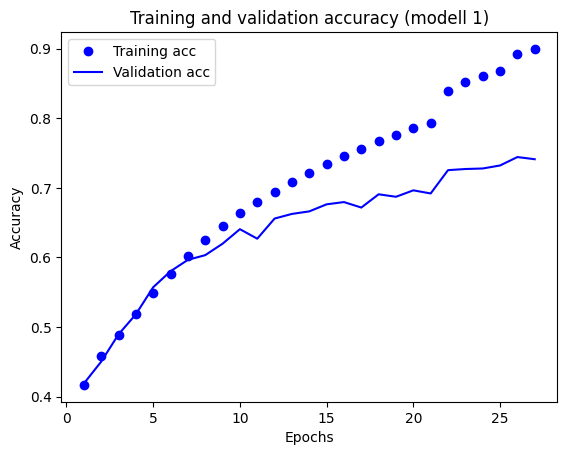

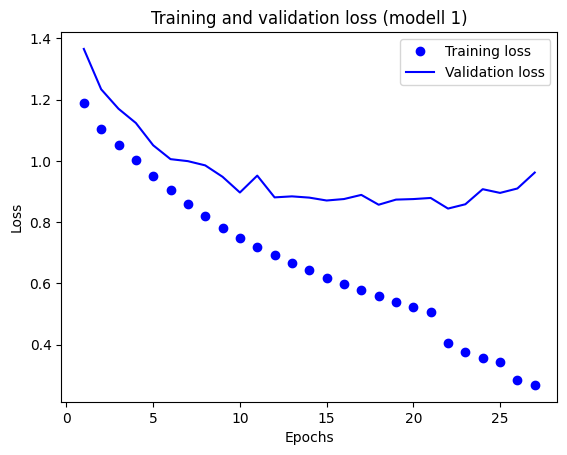

In [34]:
fitModel(sequential_model, x_train, y_train, x_val, y_val, 32, True, dist_class_weight, 1, 64)

In [35]:
# Test the model.
test_loss, test_accuracy = sequential_model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

3648/3648 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - categorical_accuracy: 0.7271 - loss: 0.8376
Test loss: 0.8390946984291077
Test accuracy: 0.726229727268219


In [36]:
# Export the model in HDF5 format
sequential_model.save('sequential_model.h5')
sequential_model.save('sequential_model.keras')

In [ ]:
from keras.models import load_model

# Load the model
loaded_model = load_model('sequential_model.h5')

In [ ]:


# Evaluate the loaded model
loaded_test_loss, loaded_test_accuracy = loaded_model.evaluate(x_test, y_test, verbose=1)
print(f"Loaded model test loss: {loaded_test_loss}")
print(f"Loaded model test accuracy: {loaded_test_accuracy}")

In [3]:
import tensorflow as tf

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Save the model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model has been converted to TensorFlow Lite and saved as 'model.tflite'")

INFO:tensorflow:Assets written to: /tmp/tmp6o6_xy2v/assets


INFO:tensorflow:Assets written to: /tmp/tmp6o6_xy2v/assets


Saved artifact at '/tmp/tmp6o6_xy2v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16, 25), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float16, name=None)
Captures:
  137744111793632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137744111691984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137744111696912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137744164238816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137744164237056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137744111682128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137744164239872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137744164237408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137744164229840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137744164231952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137744112029184: T

W0000 00:00:1742243741.989457   60149 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1742243741.989480   60149 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-17 21:35:41.990067: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6o6_xy2v
2025-03-17 21:35:41.991807: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-17 21:35:41.991825: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp6o6_xy2v
I0000 00:00:1742243742.005711   60149 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-03-17 21:35:42.008557: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-17 21:35:42.103455: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp6o6_xy2v
2025-03-17 21:35:42.131351: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

In [37]:
interpreter = tf.lite.Interpreter(model_path = "model.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 16 25]
Input Type: <class 'numpy.float32'>
Output Shape: [1 5]
Output Type: <class 'numpy.float16'>


I0000 00:00:1742244318.196042   60149 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2919 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5


In [38]:
print(x_test.shape)
print(x_test.shape)

(116711, 16, 25)
(116711, 16, 25)


In [39]:
interpreter.resize_tensor_input(input_details[0]['index'], x_test.shape)
interpreter.resize_tensor_input(output_details[0]['index'], x_test.shape)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [116711     16     25]
Input Type: <class 'numpy.float32'>
Output Shape: [116711     16     25]
Output Type: <class 'numpy.float16'>


In [ ]:

interpreter.set_tensor(input_details[0]['index'], x_test.astype(np.float32))
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

In [6]:
import os

#Print size of model.tflite in MB
print(f"Size of model.tflite: {os.path.getsize('model.tflite') / 1024 / 1024} MB")

Size of model.tflite: 1.9286079406738281 MB
